In [42]:
%load_ext autoreload
%autoreload 2

import sys
import time
sys.path.insert(0, '../')

# import embedding methods
from embedding.bernoulli import Bernoulli
from embedding.kl import KL
from embedding.matrix_factorization import MatrixFactorization

# import evaluation methods
from evaluation import evaluate_link_prediction
from evaluation import evaluate_node_classification
from evaluation import evaluate_node_clustering
# 
# import utils
from utils import graph_util
from utils import plot_util
from utils import model_util

# visualization
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Experiment 1

In [56]:
# Experiment 1

exp = {
    "max_epochs": 400,
    "learning_rate": 1e-2, #Adam
    "weight_decay": 1e-7,
    
    "link_prediction":False,
    "link_pred_num_rounds": 1,
    "link_pred_train_ratio": 0.8,
    "link_pred_eval_every_n_steps": 5,
    "link_pred_edge_emb_method": "average",
    
    "node_classification": False,
    "node_class_num_rounds": 2,
    "node_class_train_ratio": 0.8,
    "node_class_eval_every_n_steps": 5,
    
    "node_clustering": True,
    "node_clustering_num_rounds": 1,
    "node_clustering_eval_epochs": 2,
}

# pick datasets
#datasets = ["cora", "citeseer", "polblogs"] # parliament, hvr, purdue_facebook
#datasets = ["cora", "hvr", "polblogs"] 
datasets = ["cora"] #, "citeseer", "polblogs","hvr"] 

#TO DO:
#Laplacian (nobrainer) : Till done
#NetMF : Tillcd
#PPR : Till done(?)
#Sum_Power_Tran : Jan
#Sim_Rank : Jan
#Big Task: what to do with W / U Epsilon : Jan
#possible: Forest Fire / Stochastic Optimization


#Bernoulli
model_01 = Bernoulli(embedding_dimension=64, decoder='sigmoid') #works!
model_02 = Bernoulli(embedding_dimension=64, decoder='sigmoid', W_enabled=True)
model_03 = Bernoulli(embedding_dimension=64, decoder='gaussian') #works!
model_04 = Bernoulli(embedding_dimension=64, decoder='exponential') #works!
#model_05 = Bernoulli, exponential with W


#KL
#KL(similarity_measure{needs to be row stochastic}|softmax(ZZ^T))
model_06 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='ppr')
model_07 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sum_power_tran')
model_08 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sim_rank')
model_09 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='transition')
model_10 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='ppr', W_enabled=True)
model_11 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sum_power_tran', W_enabled=True)
model_12 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='sim_rank', W_enabled=True)
model_13 = KL(embedding_dimension=64, decoder='softmax', similarity_measure='transition', W_enabled=True)


#Matrix Factorization
model_14 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency', embedding_option=1) #works!
model_15 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian', embedding_option=1) 
model_16 = MatrixFactorization(embedding_dimension=64, similarity_measure='transition', embedding_option=1)
model_17 = MatrixFactorization(embedding_dimension=64, similarity_measure='sym_normalized_laplacian', embedding_option=1) #works!
model_18 = MatrixFactorization(embedding_dimension=64, similarity_measure='NetMF', embedding_option=1)
model_19 = MatrixFactorization(embedding_dimension=64, similarity_measure='ppr', embedding_option=1)
model_20 = MatrixFactorization(embedding_dimension=64, similarity_measure='sum_power_tran', embedding_option=1)
model_21 = MatrixFactorization(embedding_dimension=64, similarity_measure='sim_rank', embedding_option=1)

model_22 = MatrixFactorization(embedding_dimension=64, similarity_measure='adjacency', embedding_option=2) #works!
model_23 = MatrixFactorization(embedding_dimension=64, similarity_measure='laplacian', embedding_option=2) 
model_24 = MatrixFactorization(embedding_dimension=64, similarity_measure='transition', embedding_option=2)
model_25 = MatrixFactorization(embedding_dimension=64, similarity_measure='sym_normalized_laplacian', embedding_option=2) #works!
model_26 = MatrixFactorization(embedding_dimension=64, similarity_measure='NetMF', embedding_option=2)
model_27 = MatrixFactorization(embedding_dimension=64, similarity_measure='ppr', embedding_option=2)
model_28 = MatrixFactorization(embedding_dimension=64, similarity_measure='sum_power_tran', embedding_option=2)
model_29 = MatrixFactorization(embedding_dimension=64, similarity_measure='sim_rank', embedding_option=2)

# model_14, model_15, model_16, 
embedding_methods = [model_01,
                     model_06,model_07,model_09,
#
                     model_14,model_15,model_16,model_17,model_18,model_19,model_20
                     #model_22,model_23,model_24,model_25,model_26,model_27,
    ]
                   
#embedding_methods = [model_20]
#embedding_methods = [model_15]

# Normalized mutual information
total_NMI=[]


dset_NMI=[]

# setup folders to store experiment setup summary and results
result_folder = plot_util.setup_folders_and_summary_files(exp, datasets, embedding_methods)
print(f'The results of the current experiment are stored at experiments/{result_folder}')

for dataset in datasets:
    
    # load dataset
    total_NMI=[]
    A, y = graph_util.load_dataset(dataset)
    
  
    
    for model in embedding_methods:
        print(model._similarity_measure)
        start = time.time()
        # do link prediction
        if(exp["link_prediction"]):
            link_prediction_folder = result_folder + "/link_prediction"
            evaluate_link_prediction.expLP(A,dataset,model,exp["link_pred_num_rounds"],
                                           link_prediction_folder, train_ratio=exp["link_pred_train_ratio"], 
                                           edge_emb_method=exp["link_pred_edge_emb_method"],train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["link_pred_eval_every_n_steps"], undirected=True)
            
        # do node classification
        if(exp["node_classification"]):
            node_classification_folder = result_folder + "/node_classification"
            evaluate_node_classification.expNC(A,y,dataset,model,exp["node_class_num_rounds"],
                                               node_classification_folder, train_ratio=exp["node_class_train_ratio"],
                
                                               train_epochs=exp["max_epochs"],eval_epochs=exp["node_class_eval_every_n_steps"],undirected=True)
        if(exp["node_clustering"]):
            node_clustering_folder = result_folder + "/node_clustering"
            NMI = evaluate_node_clustering.exp_Node_Clustering(A,y,dataset,model,exp["node_clustering_num_rounds"],
                                           node_clustering_folder , train_epochs=exp["max_epochs"],
                                           eval_epochs=exp["node_clustering_eval_epochs"],undirected=True)
            total_NMI.append(NMI)
            with open('results_vis/'+dataset+str(model._method_name)+str(model._similarity_measure)
                      +'NMI_results.txt','w') as f:
                for listitem in NMI:
                    f.write('%s\n' % listitem)    
        end = time.time()
        print(f'Model evaluation took: {end-start} seconds')
    dset_NMI.append(total_NMI)

The results of the current experiment are stored at experiments/results/2020_01_17_18_09
adjacency
	Node clustering evaluation has started...
Epoch    0, loss = 0.64613
Epoch   50, loss = 0.01177
Epoch  100, loss = 0.01117
Epoch  150, loss = 0.01099
Epoch  200, loss = 0.01092
Epoch  250, loss = 0.01085
Epoch  300, loss = 0.01078
Epoch  350, loss = 0.01068
0.019504196285958487
Model evaluation took: 88.46302342414856 seconds
ppr
	Node clustering evaluation has started...
Epoch    0, loss = 0.00636
Epoch   50, loss = 0.00626
Epoch  100, loss = 0.00396
Epoch  150, loss = 0.00252
Epoch  200, loss = 0.00226
Epoch  250, loss = 0.00221
Epoch  300, loss = 0.00220
Epoch  350, loss = 0.00220
0.5059647308662552
Model evaluation took: 24.014653205871582 seconds
sum_power_tran
	Node clustering evaluation has started...
Epoch    0, loss = 0.01350
Epoch   50, loss = 0.01324
Epoch  100, loss = 0.00534
Epoch  150, loss = 0.00180
Epoch  200, loss = 0.00143
Epoch  250, loss = 0.00135
Epoch  300, loss = 0

In [46]:
len(total_NMI)

10

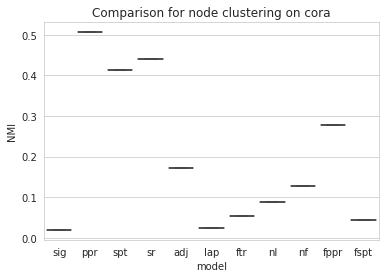

In [57]:
    
    
headers= [#'sig','exp','gau',
            'sig','ppr','spt','sr',
            'adj','lap','ftr','nl','nf', 'fppr', 'fspt'
         ]


for ds,NMI in zip(datasets,dset_NMI):
    plt.figure()
    sns_plot = sns.boxplot(x=headers, y=NMI);
    plt.title("Comparison for node clustering on "+ds)
    plt.xlabel("model")
    plt.ylabel("NMI")
    sns_plot.figure.savefig('plots/NMI_'+ds+'.png')

In [37]:
len(total_NMI)

40